## КН-410 Турик Олександр

3. Побудувати CNN на основі VGG-16 для класифікації зображень на основі  датасету fashion-mnist. 
Зробити налаштування моделі для досягнення необхідної точності. На базі  Siamese networks побудувати систему для пошуку подібних зображень в  датасеті fashion-mnist. Візуалізувати отримані результати t-SNE. 

#Fashion-mnist Labels

Each training and test example is assigned to one of the following labels:

0 T-shirt/top

1 Trouser

2 Pullover

3 Dress

4 Coat

5 Sandal

6 Shirt

7 Sneaker

8 Bag

9 Ankle boot

# 1.Import libraries and load dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.model_selection import train_test_split

In [2]:
(x,y),(x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2) 

In [4]:
x_train.dtype,y_train.dtype # unsigned int with value from 0 to 255 

(dtype('uint8'), dtype('uint8'))

In [5]:
x_train.shape, y_train.shape

((48000, 28, 28), (48000,))

In [6]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [7]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_val = x_val.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

print('Training', x_train.shape, x_train.max()) 
print('Validation',x_val.shape, x_val.max())
print('Testing', x_test.shape, x_test.max()) 


Training (48000, 28, 28, 1) 1.0
Validation (12000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


# 2.Create groups of images of each class 

In [8]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
val_groups = [x_val[np.where(y_val==i)[0]] for i in np.unique(y_val)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)] 
print('train groups:', [x.shape[0] for x in train_groups]) 
print('validation groups:',[x.shape[0] for x in val_groups])
print('test groups:', [x.shape[0] for x in test_groups]) 

train groups: [4798, 4791, 4777, 4837, 4829, 4761, 4765, 4807, 4812, 4823]
validation groups: [1202, 1209, 1223, 1163, 1171, 1239, 1235, 1193, 1188, 1177]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


#3. Generate batch with images from the same group

In [9]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

(6, 28, 28, 1) (6, 28, 28, 1) [1 1 1 0 0 0]


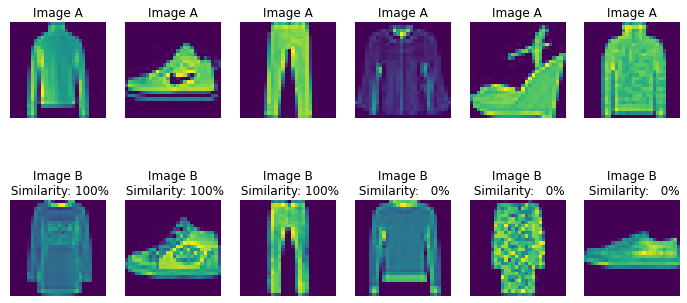

In [10]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
print(pv_a.shape,pv_b.shape,pv_sim)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

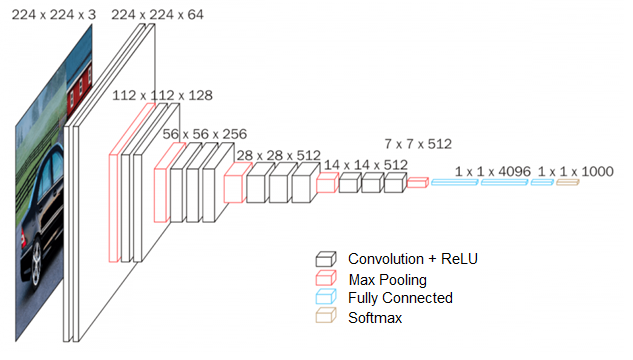

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')
n_layer = Conv2D(filters=64, kernel_size=(3,3), activation= 'relu', input_shape=(28,28,1))(img_in)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=64, kernel_size=(3,3), activation= 'relu')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(n_layer)

n_layer = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(n_layer)

n_layer = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(n_layer)

n_layer = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(n_layer)

n_layer = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(n_layer)

n_layer = Flatten()(n_layer)
n_layer = Dense(4096, activation='relu')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = Dense(4096, activation='relu')(n_layer)
n_layer = Dropout(0.5)(n_layer)

feature_model = Model(inputs=[img_in], outputs=[n_layer], name='FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                            

In [12]:
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features') # Конкатинуються фічі з 2 моделей 
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 4096)        33612992    ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 8192)         0           ['FeatureGeneratio

In [13]:
from tensorflow.keras.optimizers import Adam,SGD
similarity_model.compile(optimizer = Adam(learning_rate=1e-3),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

In [14]:
def siam_gen(in_groups, batch_size=128):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

# we want a constant validation group to have a frame of reference for model  performance 
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups),
                                    steps_per_epoch = 500, 
                                    validation_data=([valid_a, valid_b], valid_sim),
                                    epochs = 15,  verbose = True)


Epoch 1/15
500/500 [==============================] - 144s 252ms/step - loss: 0.4980 - accuracy: 0.7984 - val_loss: 0.5082 - val_accuracy: 0.8354
Epoch 2/15
500/500 [==============================] - 125s 249ms/step - loss: 0.4014 - accuracy: 0.8474 - val_loss: 0.3763 - val_accuracy: 0.8550
Epoch 3/15
500/500 [==============================] - 124s 248ms/step - loss: 0.3221 - accuracy: 0.8654 - val_loss: 0.3372 - val_accuracy: 0.8677
Epoch 4/15
500/500 [==============================] - 124s 247ms/step - loss: 0.3048 - accuracy: 0.8717 - val_loss: 0.2905 - val_accuracy: 0.8794
Epoch 5/15
500/500 [==============================] - 124s 249ms/step - loss: 0.2826 - accuracy: 0.8816 - val_loss: 0.2624 - val_accuracy: 0.8970
Epoch 6/15
500/500 [==============================] - 124s 247ms/step - loss: 0.2508 - accuracy: 0.8970 - val_loss: 0.2598 - val_accuracy: 0.8994
Epoch 7/15
500/500 [==============================] - 123s 247ms/step - loss: 0.2291 - accuracy: 0.9074 - val_loss: 0.2193 -

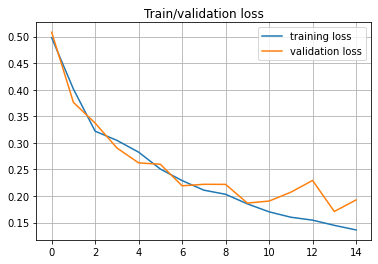

In [15]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.title('Train/validation loss')
    plt.plot(history.history['loss'], label = 'training loss')
    plt.plot(history.history['val_loss'], label = 'validation loss')
    plt.grid()
    plt.legend()
    plt.show()

plot_history(loss_history)

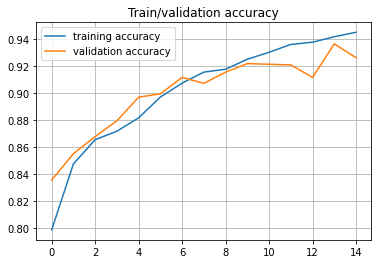

In [16]:
def plot_history(history):
    plt.title('Train/validation accuracy')
    plt.plot(history.history['accuracy'], label = 'training accuracy')
    plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
    plt.grid()
    plt.legend()
    plt.show()

plot_history(loss_history)

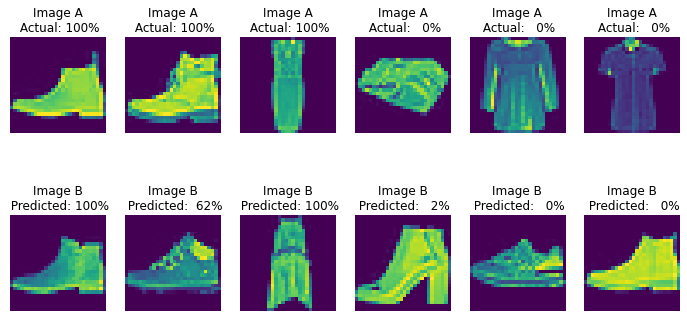

In [17]:
def show_model_output(nb_examples = 3): 
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b]) 
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T): 
        ax1.imshow(c_a[:,:,0]) 
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off') 
        ax2.imshow(c_b[:,:,0]) 
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off') 
    return fig 
    # a completely untrained model 
_ = show_model_output() 

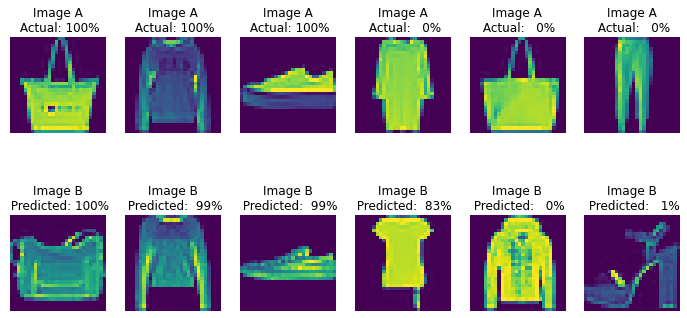

In [18]:
_ = show_model_output()

In [19]:
def find_simmilar_images(dataset, image, n_candidates=1024, finalists=4):
    candidates, preds = [], []
    for i in range(n_candidates):
        candidates.append(dataset[np.random.choice(range(len(dataset)))])
    compiled = [np.tile(image, (n_candidates, 1, 1, 1)), np.stack(candidates)]
    preds = similarity_model.predict(compiled).reshape(-1)
    top = np.argpartition(preds, -finalists)[-finalists:]
    for i in top:
        plt.imshow(candidates[i][:, :, 0])
        plt.show()
        print(preds[i])

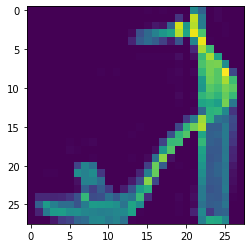

0.996784


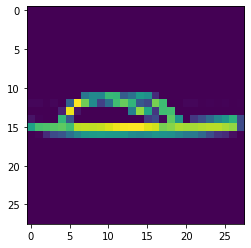

0.9968495


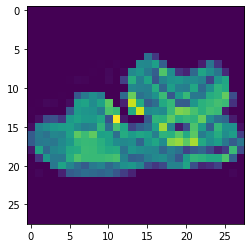

0.996912


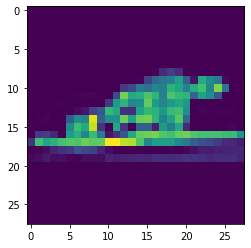

0.9969336


In [21]:
find_simmilar_images(x_val, x_val[200])

In [22]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_val.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_val],
                                         verbose = True, batch_size = 128) 
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_val.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_val],
                                            verbose = True, batch_size = 128) 

94/94 [==============================] - 7s 78ms/step


0 T-shirt/top, 1 Trouser, 2 Pullover, 3 Dress, 4 Coat

5 Sandal, 6 Shirt, 7 Sneaker, 8 Bag, 9 Ankle boot

In [23]:
t_shirt_score[:10], y_val[:10], ankle_boot_score[:10]

(array([[0.26636294],
        [0.3102973 ],
        [0.5072886 ],
        [0.9293177 ],
        [0.03176448],
        [0.13369179],
        [0.03663882],
        [0.47844365],
        [0.0394408 ],
        [0.07569491]], dtype=float32),
 array([3, 4, 6, 6, 2, 2, 2, 3, 4, 4], dtype=uint8),
 array([[1.2953228e-06],
        [9.6872522e-05],
        [4.4935925e-05],
        [2.6341131e-05],
        [8.8120389e-05],
        [1.0791303e-04],
        [7.9887701e-05],
        [3.4684085e-04],
        [8.6896318e-05],
        [4.7278310e-05]], dtype=float32))

[[0.8682684  0.9633752  0.9828635  ... 0.87521505 0.9813794  0.979118  ]]
[[1.8906279e-05 7.8328567e-06 6.7081533e-07 ... 2.4722080e-05
  8.9834106e-07 6.9593091e-07]]
[[0.01367765 0.00081804 0.00097232 ... 0.0009775  0.00063708 0.00067575]]
[[7.8742232e-05 3.7707759e-05 3.7791960e-05 ... 4.0641873e-05
  3.7344817e-05 3.6610621e-05]]
[[0.03176448 0.13369179 0.03663882 ... 0.08666841 0.04472098 0.03162962]]
[[8.8120389e-05 1.0791303e-04 7.9887701e-05 ... 6.8024776e-05
  7.8162295e-05 8.7120177e-05]]
[[0.26636294 0.47844365 0.30395377 ... 0.3042445  0.9294699  0.18105292]]
[[1.2953228e-06 3.4684085e-04 6.7516048e-06 ... 1.1852751e-06
  3.1212410e-03 1.5402152e-06]]
[[0.3102973  0.0394408  0.07569491 ... 0.10540323 0.04331524 0.00730972]]
[[9.6872522e-05 8.6896318e-05 4.7278310e-05 ... 8.3789077e-05
  1.1030078e-04 2.3915160e-05]]
[[3.1630057e-04 3.0298237e-04 2.9195429e-04 ... 2.9252880e-04
  2.0485411e-04 9.2938142e-05]]
[[0.00196476 0.00195001 0.00203269 ... 0.00204052 0.00562603 0.072

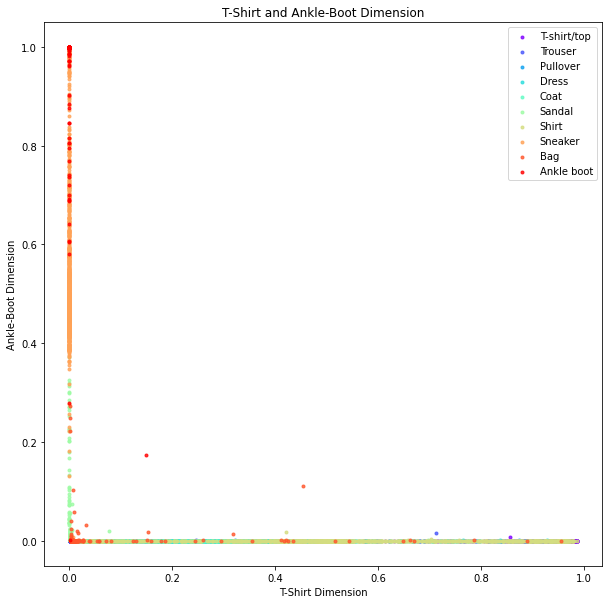

In [24]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    print(t_shirt_score[np.where(y_val == c_group),0])
    print(ankle_boot_score[np.where(y_val == c_group),0])
    plt.scatter(
        t_shirt_score[np.where(y_val == c_group), 0],
        ankle_boot_score[np.where(y_val == c_group), 0],
        marker='.',
        color=c_color,
        linewidth='1',
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [25]:
x_test_features = feature_model.predict(
    x_val,
    verbose=True,
    batch_size=128
)

94/94 [==============================] - 4s 38ms/step


In [26]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.047s...
[t-SNE] Computed neighbors for 12000 samples in 38.704s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 101.390503
[t-SNE] Computed c

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 66.8921890, gradient norm = 0.0023044 (50 iterations in 7.652s)
[t-SNE] Iteration 100: error = 84.0405731, gradient norm = 0.0033601 (50 iterations in 7.833s)
[t-SNE] Iteration 150: error = 105.4825516, gradient norm = 0.0049330 (50 iterations in 7.187s)
[t-SNE] Iteration 200: error = 106.9363251, gradient norm = 0.0049877 (50 iterations in 7.162s)
[t-SNE] Iteration 250: error = 106.9181976, gradient norm = 0.0046471 (50 iterations in 7.187s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.918198
[t-SNE] Iteration 300: error = 3.0854800, gradient norm = 0.0013220 (50 iterations in 6.999s)
[t-SNE] Iteration 350: error = 2.6465230, gradient norm = 0.0005089 (50 iterations in 7.065s)
[t-SNE] Iteration 400: error = 2.4787998, gradient norm = 0.0003012 (50 iterations in 7.102s)
[t-SNE] Iteration 450: error = 2.3793554, gradient norm = 0.0002170 (50 iterations in 7.088s)
[t-SNE] Iteration 500: error = 2.3066039, gradient norm = 0.0001721 

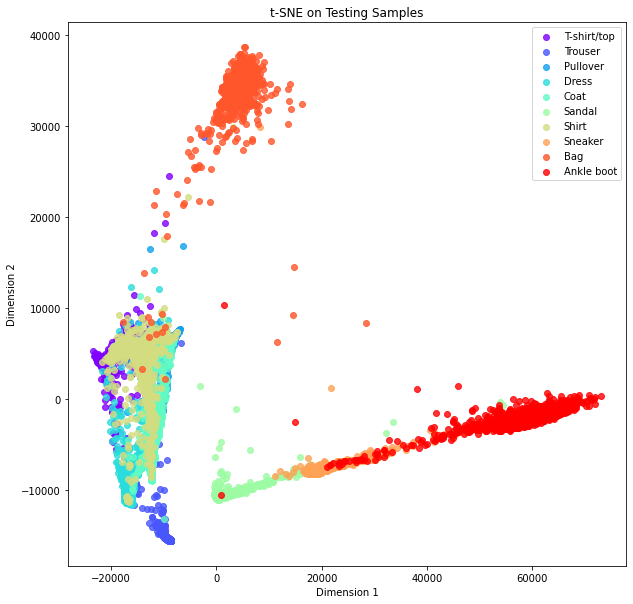

In [27]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_val == c_group), 0],
        tsne_features[np.where(y_val == c_group), 1],
        marker='o',
        color=c_color,
        linewidth='1',
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)